## Tradeoff Problem Example: Podracing


We are entered in the race of the century! Just like Anakin Skywalker, we built our own podracer and are about to begin the race. The official informs us that there are certain “checkpoints” that we need to hit. Our goal is to save as much fuel as possible so we don’t run out during the race.

Before we start the race, we must figure out the appropriate thruster burns at each instant.

- We'll (approximately) model thrust as a 2D vector containing info on direction change

- Amount of fuel we consume when we use thrusters is calculated as L2 norm of thrust vector

- Suppose the officials aren’t watching the checkpoints very closely, so long as we “sort of” hit the checkpoints we’ll be okay

In [19]:
T

4-element Vector{Int64}:
  1
 20
 50
 60

In [13]:
x

2×60 Matrix{Float64}:
 1.0  1.0  1.02459  1.07254  1.1426   1.23352  …  2.15805  1.60233   1.04237
 1.0  1.0  1.02843  1.08229  1.15857  1.25428     0.71268  0.843225  0.976154

In [20]:
println(x[:,3]) # location at 3 seconds
println()
println(x[:,20]) # location at 20 seconds
println()
println(x[:,50]) # location at 50 seconds
println()
println(x[:,60]) # location at 60 seconds

[1.024594039596167, 1.0284287016908094]

[4.002456821817297, 2.9535144420725423]

[5.9427531412311, 0.04032343523581149]

[1.0423738971147334, 0.976153933347551]


In [24]:
v

LoadError: UndefVarError: v not defined

In [32]:
using JuMP, Gurobi

k = 4              # number of checkpoints
T = zeros(Int,k)   # vector of timepoints
xw = zeros(2,k)    # vector of checkpoint locations

# times at which we must hit checkpoints
T[1] = 1
T[2] = 20
T[3] = 50
T[4] = 60

# define checkpoints' x and y coords
way_xy = [ 1   4   6   1
           1   3   0   1 ]

# create a function that takes a value for λ then solves and reports solution of tradeoff problem
function solveOpt(λ)
    
    m = Model(Gurobi.Optimizer) # need Gurobi since it's nonlinear
    set_optimizer_attribute(m,"OutputFlag",0)
    @variable(m, x[1:2,1:T[k]])  # position at each time / 2 x 60 matrix
    @variable(m, v[1:2,1:T[k]])  # velocity at each time / 2 x 60 matrix
    @variable(m, u[1:2,1:T[k]])  # thruster input at each time / 2 x 60 matrix

    # satisfy the dynamics (with zero initial velocity)
    @constraint(m, v[:,1] .== [0;0]) # intial velocity
    @constraint(m, x[:,1] .== [1;1]) # initial starting point
    
    # model system dynamics
    for t in 1:T[k]-1 # 1 ~ 59
        @constraint(m, x[:,t+1] .== x[:,t] + v[:,t])
        @constraint(m, v[:,t+1] .== v[:,t] + u[:,t])
    end

    ### COMMENT AND UNCOMMENT(only when setting λ = 0 below) DEPENDING ON WHETHER CHECKPOINTS ARE CONSTRAINTS ###
    # hit all the checkpoints
#     for i in 1:k
#         @constraint(m, x[:,T[i]] .== way_xy[:,i])
#     end

    # hit the first checkpoint only
     for i in 1
         @constraint(m, x[:,T[i]] .== way_xy[:,i])
     end
    
    # minimize 2-norm (THIS IS LEAST-SQUARES)
    @objective(m, Min, sum(u.^2) + λ*sum( (x[:,T]-way_xy).^2 ) )
    optimize!(m)
    y1 = value(sum(u.^2))
    y2 = value(sum( (x[:,T]-way_xy).^2  ))
    xopt = value.(x)
    
    return (y1,y2,xopt)
end
;

### Plot Model Output

We can visualize our solution by plotting the output below:

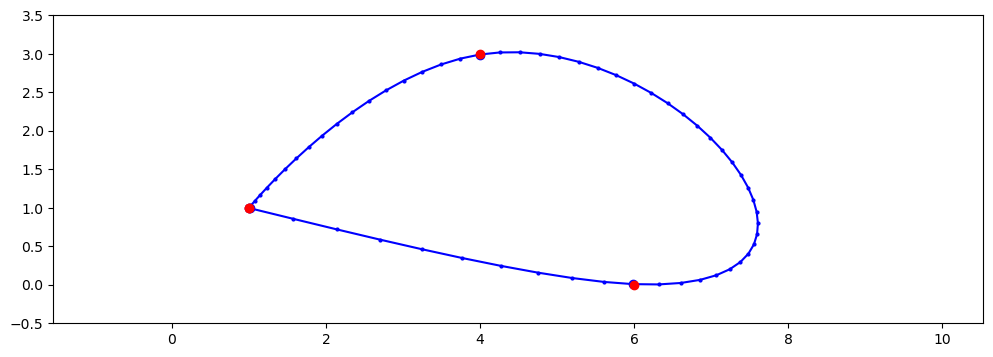

Academic license - for non-commercial use only - expires 2022-07-06


In [34]:
λ = 0.5 # choose a value for λ
(y1x,y2x,x) = solveOpt(λ) # solve model with given λ

# plot the solution against the checkpoints
using PyPlot
figure(figsize=(12,4))
plot(x[1,:], x[2,:], "b.-", markersize=4)
plot(x[1,:][T], x[2,:][T], "b.", markersize=12)
plot(way_xy[1,:], way_xy[2,:], "r.", markersize=12)
axis("equal")
axis((1.,8.,-.5,3.5));